# Sentiment Driven Stock Predictions

## Open source software - 
Numerous open source libraries were used in this project including all of the below and any others not mentioned

* Pandas
* Numpy
* Sklearn
* Matplotlib
* Transformers
* XGBoost
* Statsmodels
* Vadersentiment
* Seaborn

## Importing Data

In [2]:
# First, mount your drive (might happen automatically)
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi

Mounted at /content/drive
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



### First time downloading data to drive

In [ ]:
## First time import to transfer data from kaggle to Google Drive

## alternatively just download a dataset and upload it to your google drive

## Generate an API key using the instructions on this site - https://medium.com/analytics-vidhya/how-to-directly-download-kaggle-dataset-to-google-drive-aa06175712e2
## Next, on the files tab on the left browse to content and transfer the downloaded files from /content to "MyDrive"

#  import os

# os.environ['KAGGLE_USERNAME'] = "your username"
# os.environ['KAGGLE_KEY'] = "your api key"

# !kaggle datasets download -d aaron7sun/stocknews

### Normal data import

In [3]:
# Once data has already been transferred, use this to import data from your drive

!cp '/content/drive/MyDrive/ECE 579 Project/stooq_all_us_daily_data.zip' .
!cp '/content/drive/MyDrive/ECE 579 Project/stocknews.zip' .
#!cp '/content/drive/MyDrive/ECE 579/ECE579_TermProject/Code/Data/tweets-about-the-top-companies-from-2015-to-2020.zip' .

# make folder structure
!mkdir stock_data
!mkdir stock_news
#!mkdir tweets

# unzip files
!unzip -q stooq_all_us_daily_data.zip -d stock_data
#!unzip -q tweets-about-the-top-companies-from-2015-to-2020 -d tweets
!unzip -q stocknews.zip -d stock_news

!ls

drive	     stock_data  stocknews.zip
sample_data  stock_news  stooq_all_us_daily_data.zip


In [4]:
import pandas as pd

#reshape reddit data to match news headlines

r_data =  pd.read_csv('/content/stock_news/RedditNews.csv')
foo = lambda a: " / ".join(a) 
reddit_data = r_data.groupby(by=['Date']).agg({'News':foo}).reset_index()
reddit_data

,Date,News
0,2008-06-08,b'Nim Chimpsky: The tragedy of the chimp who t...
1,2008-06-09,b'United States quits Human Rights Council' / ...
2,2008-06-10,"b'Oil shortage a myth, says industry insider' ..."
3,2008-06-11,b'BBC uncovers lost Iraq billions' / b'War Cri...
4,2008-06-12,"b'Did US attack Pakistan last night? ""Pakistan..."
...,...,...
2938,2016-06-27,Barclays and RBS shares suspended from trading...
2939,2016-06-28,"2,500 Scientists To Australia: If You Want To ..."
2940,2016-06-29,Explosion At Airport In Istanbul / Yemeni form...
2941,2016-06-30,Jamaica proposes marijuana dispensers for tour...


### Stock data class

In [5]:
# class for stock data
import os
import pandas as pd
from datetime import datetime, date
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt 
%matplotlib inline

class Stock_data():
  
  def __init__(self, symbol, historical = True, timeframe = 'daily', source_folder = '/content/stock_data/data/daily/us'):
    self.symbol = symbol + '.us.txt'
    self.historical = historical
    self.timeframe = timeframe
    self.source_folder = source_folder
    self.data = pd.DataFrame()

    # get csv path from symbol by searching
    for root, dirs, files in os.walk(self.source_folder):
      if self.symbol in files:
        self.csv_path = os.path.join(root, self.symbol)

    if not self.csv_path:
      print('Error, symbol not found')
  
    # import data
    if historical == True & bool(timeframe == 'daily'):
      self.import_data()

  # function for importing data
  def import_data(self):
    self.data = pd.read_csv(self.csv_path, parse_dates=['<DATE>'],
                            date_parser=lambda x: datetime.strptime(x, '%Y%m%d')) #index_col = '<DATE>', 

  # removes excess columns
  def clean_data(self):
    del self.data['<TICKER>']
    del self.data['<PER>']
    del self.data['<OPENINT>']
    del self.data['<TIME>']

  # gets data from a range of dates
  def get_daterange(self, start_date, end_date, data = 0):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data = temp_data.loc[(temp_data['<DATE>'] <= end_date) & (temp_data['<DATE>'] >= start_date)]
    temp_data = temp_data.reset_index()
    return temp_data

  # returns input data with a binary label depending on if the stock price went up or down that day
  def get_binarylabel(self, data):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] > 0, 'Label'] = int(1)
    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] <= 0, 'Label'] = int(0)
    return temp_data

  def get_laggedbinarylabel(self, lag=1, data = 0):
    if data:
      temp_data = data
    else:
      temp_data = data

    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] > 0, 'Label'] = int(1)
    temp_data.loc[temp_data['<CLOSE>'] - temp_data['<OPEN>'] <= 0, 'Label'] = int(0)
    return temp_data

  def get_renamed(self):
    return self.data.rename(columns = {'<DATE>':'Date', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'}, inplace = True) 

  def set_data(self, dataframe):
    self.data = dataframe

  def get_data(self):
    return self.data


# function to report performance metrics
def report(labels, predictions):

  # Report accuracy on test data
  matrix = confusion_matrix(labels, predictions)
  print('Confusion Matrix')
  print(matrix)
  print()
  score = accuracy_score(labels, predictions)
  print('Overall prediction accuracy: ' + str(score) + '\n')
  report = classification_report(labels, predictions)
  print('Classification Report: ')
  print(report)


In [6]:
# import stock data by setting up data class
# imports djia data (dia etf)
dia_data = Stock_data('dia')
# uses clean function of data class to remove excess columns
dia_data.clean_data()

# same for s&p 500 (spy etc) dataset
spy_data = Stock_data('spy')
spy_data.clean_data()

# same for nasdaq (qqq)
qqq_data = Stock_data('qqq')
qqq_data.clean_data()

# make sure data looks right
print(dia_data.data)

         <DATE>    <OPEN>    <HIGH>    <LOW>  <CLOSE>     <VOL>
0    2005-02-25   87.6640   88.4780   87.571   88.428   6101982
1    2005-02-28   88.2250   88.9380   87.535   87.891   9135557
2    2005-03-01   87.9500   88.5290   87.950   88.324   6510615
3    2005-03-02   87.9850   88.7010   87.932   88.192   9343052
4    2005-03-03   88.4780   88.6830   87.836   88.341  10124004
...         ...       ...       ...      ...      ...       ...
4009 2021-02-01  302.2800  303.3500  300.140  302.020   3138644
4010 2021-02-02  304.5399  308.4300  304.520  306.820   3090522
4011 2021-02-03  306.1000  307.9353  305.180  307.260   2087820
4012 2021-02-04  307.8500  310.6700  307.770  310.670   2638783
4013 2021-02-05  312.3600  312.5500  310.870  311.540   1955091

[4014 rows x 6 columns]


## Sentiment Analysis

In [7]:
# Displaying news headlines dataset

df = pd.read_csv('stock_news/Combined_News_DJIA.csv')
df

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

### News

#### Random Forrest/ Bag of Words

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

class RandomForrestSentiment():

  def __init__(self, stock_dataset, news_dataset_path = 'stock_news/Combined_News_DJIA.csv'):
    self.news_path = news_dataset_path
    self.stock_data = stock_dataset
    self.news_data = pd.read_csv(news_dataset_path)

# -----------------------------------------------------------------------------------
  #DATA PREP
  # sets up news dataset for random forrest
  def prepare_news_data(self, data = 0, label = 'source'):
    if label != 'source':
    # allows using next day's stock change by providing stock dataframe, can make this better
      if data:
        self.news_data['Label']  = data['Label'].astype(int)

    # split data
    self.train = self.news_data[self.news_data['Date'] < '20150101']
    self.test = self.news_data[self.news_data['Date'] > '20141231']

    # remove extra indices
    self.data = self.train.iloc[:, 2:27]

    # remove non alphabetical characters
    self.data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

    # rename columns
    list1 = [i for i in range(25)]
    new_Index = [str(i) for i in list1]
    self.data.columns = new_Index

    # make everything lowercase
    for index in new_Index:
        self.data[index] = self.data[index].str.lower()

    # create list for each row merging all headlines into one
    self.headlines = []
    for row in range(0, len(self.data.index)):
        self.headlines.append(' '.join(str(x) for x in self.data.iloc[row, 0:25]))

  def prepare_reddit_data(self):
    self.r_data =  pd.read_csv('/content/stock_news/RedditNews.csv')
    foo = lambda a: " / ".join(a) 
    self.reddit_data = self.r_data.groupby(by=['Date']).agg({'News':foo}).reset_index()
    
    #remove weekends/ non-trading days
    self.labels_tradingdays = self.news_data.iloc[:, 0:2]
    self.reddit_data = pd.merge(left=self.reddit_data, right=self.labels_tradingdays)

    self.reddit_data['News'].replace("[^a-zA-Z]", " ", regex=True, inplace=True)
    self.reddit_data['News'].str.lower()

    self.train = self.reddit_data.loc[(reddit_data['Date'] >= '20080812') & (reddit_data['Date'] < '20150101')]
    self.train = self.train.reset_index()
    self.train['Label'] = self.news_data[self.news_data['Date'] < '20150101']['Label']

    self.test = self.reddit_data[self.reddit_data['Date'] > '20141231']
    self.test['Label'] = self.news_data[self.news_data['Date'] > '20141231']['Label']
    self.test = self.test.reset_index()

    self.headlines = self.train['News'].to_list()


# -----------------------------------------------------------------------------------
  #TOKENIZATION
  def tokenize_data(self, bag = True, ngrams = 3): #original value of 2
    # convert all sentences into vectors
    self.countVector = CountVectorizer(ngram_range=(ngrams, ngrams))
    #ngram(2,2) means it will combine the 2 words together and assign the value

    # bag of words
    if bag:
      self.trainDataset = self.countVector.fit_transform(self.headlines)

  def train_model(self):
    # Setup random forest classifier and train
    self.randomClassifier = RandomForestClassifier(n_estimators=50, criterion='entropy') #original values of 15, 200, etc.
    self.randomClassifier.fit(self.trainDataset, self.train['Label'])

  def test_model(self, reddit=False):
    # predict for test data
    self.testTransform =[]

    if reddit == False:
        for row in range(0, len(self.test.index)):
          self.testTransform.append(' '.join(str(x) for x in self.test.iloc[row, 2:27]))
    else:
      self.testTransform = self.test['News'].to_list()

    self.test_dataset = self.countVector.transform(self.testTransform)

    self.predictions = self.randomClassifier.predict(self.test_dataset)

  def get_performance_report(self):
    report(self.test['Label'], self.predictions)


In [9]:
generic_forrest = RandomForrestSentiment(dia_data)
generic_forrest.prepare_news_data()
generic_forrest.tokenize_data()
generic_forrest.train_model()
generic_forrest.test_model()
generic_forrest.get_performance_report()

Confusion Matrix
[[128  58]
 [  0 192]]

Overall prediction accuracy: 0.8465608465608465

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.69      0.82       186
           1       0.77      1.00      0.87       192

    accuracy                           0.85       378
   macro avg       0.88      0.84      0.84       378
weighted avg       0.88      0.85      0.84       378



In [10]:
reddit_forrest = RandomForrestSentiment(dia_data)
reddit_forrest.prepare_reddit_data()
reddit_forrest.tokenize_data()
reddit_forrest.train_model()
reddit_forrest.test_model(reddit=True)
reddit_forrest.get_performance_report()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Confusion Matrix
[[ 96  90]
 [ 85 107]]

Overall prediction accuracy: 0.5370370370370371

Classification Report: 
              precision    recall  f1-score   support

           0       0.53      0.52      0.52       186
           1       0.54      0.56      0.55       192

    accuracy                           0.54       378
   macro avg       0.54      0.54      0.54       378
weighted avg       0.54      0.54      0.54       378



In [11]:
news_data = generic_forrest.news_data
r_data =  pd.read_csv('/content/stock_news/RedditNews.csv')
foo = lambda a: " / ".join(a) 
reddit_data = r_data.groupby(by=['Date']).agg({'News':foo}).reset_index()

labels_tradingdays = news_data.iloc[:, 0:2]
reddit_data = pd.merge(left=reddit_data, right=labels_tradingdays)
reddit_data

,Date,News,Label
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...",0
1,2008-08-11,b'Why wont America and Nato help us? If they w...,1
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...,0
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...,0
4,2008-08-14,b'All the experts admit that we should legalis...,1
...,...,...,...
1984,2016-06-27,Barclays and RBS shares suspended from trading...,0
1985,2016-06-28,"2,500 Scientists To Australia: If You Want To ...",1
1986,2016-06-29,Explosion At Airport In Istanbul / Yemeni form...,1
1987,2016-06-30,Jamaica proposes marijuana dispensers for tour...,1


### DistilBERT

In [11]:
# Prep all data for headlines
# remove extra indices

data = df.iloc[:, 2:27]

# remove non alphabetical characters
data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

# rename columns
list1 = [i for i in range(25)]
new_Index = [str(i) for i in list1]
data.columns = new_Index

# make everything lowercase
for index in new_Index:
    data[index] = data[index].str.lower()

# create list for each row merging all headlines into one
news_headlines = []
for row in range(0, len(data.index)):
    news_headlines.append(' '.join(str(x) for x in data.iloc[row, 0:25]))

In [12]:
!pip install transformers

     |████████████████████████████████| 2.0MB 14.9MB/s 
     |████████████████████████████████| 3.3MB 50.5MB/s 
     |████████████████████████████████| 870kB 51.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=543e5f8e4f0f608a133896714333b1ba132dbc82e07ef41113fe38c2fbc59aad
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [13]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

In [14]:
# # Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [15]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)
# tokenizer = Tokenizer.from_pretrained('distilgpt2', truncation=True, do_lower_case=True)

In [16]:
class LabelDataset(Dataset):

  def __init__(self, dataframe, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.text = dataframe.Headlines
    self.targets = self.data.Labels
    self.max_len = max_len

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = str(self.text[index])
    text = " ".join(text.split())

    inputs = self.tokenizer.encode_plus(
      text,
      None,
      add_special_tokens=True,
      max_length=self.max_len,
      pad_to_max_length=True,
      return_token_type_ids=True
    )
    ids = inputs['input_ids']
    mask = inputs['attention_mask']
    token_type_ids = inputs["token_type_ids"]


    return {
      'ids': torch.tensor(ids, dtype=torch.long),
      'mask': torch.tensor(mask, dtype=torch.long),
      'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
      'targets': torch.tensor(self.targets[index], dtype=torch.float)
    }

In [25]:
# Creating the dataset and dataloader for the neural network
train_dat = pd.DataFrame()
train_dat['Headlines'] = reddit_forrest.headlines#news_headlines # reddit_forrest.headlines
train_dat['Labels'] = df['Label']
# train_dat['Labels'] = stock_lagged['Label']
# train_dat['Labels'] = generic_forrest.news_data['Label']
train_dat['Labels'] = train_dat.iloc[:, 1:].values.tolist()
train_dat['Date'] = df['Date']
train_dat

new_df = train_dat

# train_size = 0.8
# train_data=new_df.sample(frac=train_size,random_state=200)
# test_data=new_df.drop(train_data.index).reset_index(drop=True)
# train_data = train_data.reset_index(drop=True)

# Split data
train_data = new_df[new_df['Date'] < '2014-10-01']
test_data = new_df[new_df['Date'] >= '2014-10-01']
# test_data = new_df.loc[(new_df['Date'] >= '2014-10-01') & (new_df['Date'] <= '2015-07-01')]
# val_data = new_df[new_df['Date'] > '2015-07-01']

del train_data['Date']
del test_data['Date']
# del val_data['Date']

test_data = test_data.reset_index()
# val_data = val_data.reset_index()

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))
# print("VAL Dataset: {}".format(val_data.shape))

training_set = LabelDataset(train_data, tokenizer, MAX_LEN)
testing_set = LabelDataset(test_data, tokenizer, MAX_LEN)
# validation_set = LabelDataset(val_data, tokenizer, MAX_LEN)

FULL Dataset: (1782, 3)
TRAIN Dataset: (1547, 2)
TEST Dataset: (235, 3)


In [26]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)
# validation_loader = DataLoader(validation_set, ** val_params)

In [27]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Example source: https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=FeftvDhjDSPp

class DistilBERTClass(torch.nn.Module):
  def __init__(self):
    super(DistilBERTClass, self).__init__()
    # self.l1 = DistilBertModel.from_pretrained("distilgpt2")
    self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
    self.pre_classifier = torch.nn.Linear(768, 768)
    self.dropout = torch.nn.Dropout(0.1)
    self.classifier = torch.nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask, token_type_ids):
    output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
    hidden_state = output_1[0]
    pooler = hidden_state[:, 0]
    pooler = self.pre_classifier(pooler)
    pooler = torch.nn.Tanh()(pooler)
    pooler = self.dropout(pooler)
    output = self.classifier(pooler)
    return output

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [28]:
def loss_fn(outputs, targets):
  return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

def train_model(epoch):
  model.train()
  for _,data in tqdm(enumerate(training_loader, 0)):
    ids = data['ids'].to(device, dtype = torch.long)
    mask = data['mask'].to(device, dtype = torch.long)
    token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.float)

    outputs = model(ids, mask, token_type_ids)

    optimizer.zero_grad()
    loss = loss_fn(outputs, targets)
    if _%5000==0:
      print(f'Epoch: {epoch}, Loss:  {loss.item()}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [29]:
for epoch in range(EPOCHS):
    train_model(epoch)

1it [00:00,  3.29it/s]

Epoch: 0, Loss:  0.668325662612915


387it [01:36,  4.02it/s]
1it [00:00,  4.16it/s]

Epoch: 1, Loss:  0.7669241428375244


387it [01:35,  4.04it/s]
1it [00:00,  4.28it/s]

Epoch: 2, Loss:  0.7706451416015625


387it [01:35,  4.04it/s]
1it [00:00,  4.12it/s]

Epoch: 3, Loss:  0.5321630239486694


387it [01:35,  4.03it/s]
1it [00:00,  4.23it/s]

Epoch: 4, Loss:  0.16161087155342102


387it [01:35,  4.03it/s]


In [30]:
def validation(testing_loader):
  model.eval()
  fin_targets=[]
  fin_outputs=[]
  with torch.no_grad():
    for _, data in tqdm(enumerate(testing_loader, 0)):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)
      outputs = model(ids, mask, token_type_ids)
      fin_targets.extend(targets.cpu().detach().numpy().tolist())
      fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
  return fin_outputs, fin_targets

In [31]:
outputs, targets = validation(testing_loader)

# val_out, val_targets = validation(validation_loader)
# val_outputs = np.array(val_out) >= 0.5

final_outputs = np.array(outputs) >=0.5

59it [00:05, 10.34it/s]


In [33]:
# Saving the files to drive

output_model_file = "/content/drive/MyDrive/ECE 579 Project/models/distilbert_model_reddit.bin"
output_vocab_file = "/content/drive/MyDrive/ECE 579 Project/models/vocab_reddit.bin"

torch.save(model, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('Saved')

Saved


In [32]:
report(targets, final_outputs.astype(int))

Confusion Matrix
[[ 16 103]
 [ 26  90]]

Overall prediction accuracy: 0.451063829787234

Classification Report: 
              precision    recall  f1-score   support

         0.0       0.38      0.13      0.20       119
         1.0       0.47      0.78      0.58       116

    accuracy                           0.45       235
   macro avg       0.42      0.46      0.39       235
weighted avg       0.42      0.45      0.39       235



In [ ]:
# report(val_targets, val_outputs.astype(int))

### Vadersentiment

In [12]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 4.9MB/s 


In [13]:
# Prep all data for headlines
# remove extra indices

data = df.iloc[:, 2:27]

# remove non alphabetical characters
data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)

# rename columns
list1 = [i for i in range(25)]
new_Index = [str(i) for i in list1]
data.columns = new_Index

# make everything lowercase
for index in new_Index:
    data[index] = data[index].str.lower()

# create list for each row merging all headlines into one
news_headlines = []
for row in range(0, len(data.index)):
    news_headlines.append(' '.join(str(x) for x in data.iloc[row, 0:25]))

In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()
out = []

# use headlines list from generic_forrest - since vadersentiment is a pre-trained tool no training is required
for item in range(0, len(reddit_forrest.headlines)): #news_headlines
  out.append(vader_analyzer.polarity_scores(news_headlines[item]))

vader_output = pd.DataFrame(out, columns=['neg', 'neu', 'pos', 'compound'])

In [15]:
vader_accuracy = pd.DataFrame()

vader_accuracy['Prediction'] = vader_output['compound']
vader_accuracy['Label'] = df['Label']

vader_accuracy.loc[vader_accuracy['Prediction'] >= 0, 'Rounded'] = 1
vader_accuracy.loc[vader_accuracy['Prediction'] < 0, 'Rounded'] = 0

report(vader_accuracy['Label'], vader_accuracy['Rounded'])

Confusion Matrix
[[818  11]
 [941  12]]

Overall prediction accuracy: 0.4657687991021324

Classification Report: 
              precision    recall  f1-score   support

           0       0.47      0.99      0.63       829
           1       0.52      0.01      0.02       953

    accuracy                           0.47      1782
   macro avg       0.49      0.50      0.33      1782
weighted avg       0.50      0.47      0.31      1782



## XGBoost

In [16]:
rf_labels = pd.DataFrame(df['Label'].loc[(df['Date'] < '20141231')])
rf_labels = rf_labels['Label'].append(pd.Series(name = 'Label', data = generic_forrest.predictions), ignore_index = True)
rf_labels = rf_labels.rename('RandomForrest')

start_date = '2008-08-08'
end_date = '2016-06-28'
test_stock_data = dia_data.data.loc[(dia_data.data['<DATE>'] >= start_date) & (dia_data.data['<DATE>'] <= end_date)]

stock_with_predictions = test_stock_data.reset_index()
del stock_with_predictions['index']
stock_with_predictions['Predictions'] = rf_labels
stock_with_predictions

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,Predictions
0,2008-08-08,93.219,96.008,93.057,95.446,38254036,0
1,2008-08-11,95.483,96.908,95.307,96.136,27554381,1
2,2008-08-12,95.841,95.901,94.717,95.121,27502355,0
3,2008-08-13,94.717,94.813,93.608,94.189,34546335,0
4,2008-08-14,93.738,95.744,93.608,94.992,30158885,1
...,...,...,...,...,...,...,...
1980,2016-06-22,164.530,165.170,163.780,163.920,3205796,1
1981,2016-06-23,165.220,165.970,164.920,165.970,3167600,1
1982,2016-06-24,161.120,163.080,159.970,160.270,12324106,1
1983,2016-06-27,159.180,159.180,157.260,158.010,8327343,1


In [17]:
def xgboost_data_gen(stock_data):
  # Building input data - including stock data, sentiment, technical indicators (RSI/ MA/ etc.)
  # stock data
  start_date = '2008-08-08'
  end_date = '2016-06-28'
  test_stock_data = stock_data
  test_stock_data = test_stock_data.loc[(test_stock_data['<DATE>'] >= start_date) & (test_stock_data['<DATE>'] <= end_date)]
  test_stock_data = test_stock_data.reset_index()

  # # random forrest output
  # rf_labels = pd.DataFrame(df['Label'].loc[(df['Date'] < '20141231')])
  # rf_labels = rf_labels['Label'].append(pd.Series(name = 'Label', data = generic_forrest.predictions), ignore_index = True)
  # rf_labels = rf_labels.rename('RandomForrest')

  # technical indicators
  # moving average columns
  test_stock_data['MA5'] = test_stock_data['<CLOSE>'].rolling(window=5).mean()
  test_stock_data['MA10'] = test_stock_data['<CLOSE>'].rolling(window=10).mean()
  test_stock_data['MA20'] = test_stock_data['<CLOSE>'].rolling(window=20).mean()
  test_stock_data['MA50'] = test_stock_data['<CLOSE>'].rolling(window=50).mean()
  test_stock_data['MA200'] = test_stock_data['<CLOSE>'].rolling(window=200).mean()

  # Force Index (ForceIndex)
  test_stock_data['FI'] = test_stock_data['<CLOSE>'].diff(1) * test_stock_data['<VOL>']

  # final concat of data inputs    
  xgboost_data = pd.concat([test_stock_data], axis=1, join='inner') #vader_output, rf_labels,
  # rename columns since xgboost doesn't like <>
  xgboost_data.rename(columns = {'<DATE>':'Date', '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close', '<VOL>':'Vol'}, inplace = True)
  # get rid of old index
  del xgboost_data['index']

  # make sure data looks good
  return xgboost_data

In [18]:
def xgboost_split(xg_data):

  # split into test and train around 2014-10-01
  X_train = xg_data[xg_data['Date'] < '2015-01-01']
  del X_train['Date']
  X_test = xg_data[xg_data['Date'] >= '2015-01-01']
  del X_test['Date']
  y_train = df[df['Date'] < '2014-12-31']['Label']
  y_test = df[df['Date'] >= '2014-12-31']['Label']

  # remove some extra data pieces.... (not sure why these are here)
  y_test.pop(1985)
  y_test.pop(1986)
  y_test.pop(1987)
  y_test.pop(1988)

  return X_train, X_test, y_train, y_test

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def xg_train(X_train, X_test, y_train, y_test):
  # setup xgboost classifier (binary classifier)
  model = XGBClassifier(max_depth = 50, n_estimators = 500, learning_rate = 0.01)
  # train model
  model.fit(X_train, y_train)
  # predict test data
  y_pred = model.predict(X_test)
  # display accuracy
  accu_score = accuracy_score(y_test, y_pred)
  return model, y_pred

In [20]:
import seaborn as sns
import numpy as np

def xg_importance(model, data):
  # plot feature importance in classifier
  indices = np.argsort(model.feature_importances_)[::-1]

  features = []
  for i in range(10):
      features.append(data.columns[indices[i]])

  fig, ax = plt.subplots(figsize=(15,5))     

  sns.barplot(x=features, y=model.feature_importances_[indices[range(10)]],\
  label="Importtant Categorical Features", palette=("Blues_d"),ax=ax).\
  set_title('Categorical Features Importance')

  ax.set(xlabel="Columns", ylabel = "Importance")

In [22]:
xgboost_data_dia = xgboost_data_gen(stock_with_predictions)
# xgboost_data_spy = xgboost_data_gen(spy_data)
# xgboost_data_qqq = xgboost_data_gen(qqq_data)

X_train_dia, X_test_dia, y_train_dia, y_test_dia = xgboost_split(xgboost_data_dia)
# X_train_spy, X_test_spy, y_train_spy, y_test_spy = xgboost_split(xgboost_data_spy)
# X_train_qqq, X_test_qqq, y_train_qqq, y_test_qqq = xgboost_split(xgboost_data_qqq)

dia_model, dia_pred = xg_train(X_train_dia, X_test_dia, y_train_dia, y_test_dia)
report(y_test_dia, dia_pred)
# spy_model, spy_pred = xg_train(X_train_spy, X_test_spy, y_train_spy, y_test_spy)
# qqq_model, qqq_pred = xg_train(X_train_qqq, X_test_qqq, y_train_qqq, y_test_qqq)

0.8453333333333334
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       129
           1       1.00      0.76      0.87       246

    accuracy                           0.85       375
   macro avg       0.84      0.88      0.84       375
weighted avg       0.89      0.85      0.85       375

Confusion Matrix
[[129  58]
 [  0 188]]

Overall prediction accuracy: 0.8453333333333334

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.69      0.82       187
           1       0.76      1.00      0.87       188

    accuracy                           0.85       375
   macro avg       0.88      0.84      0.84       375
weighted avg       0.88      0.85      0.84       375



## ARIMA

In [23]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
#split data
train_arima_data = stock_with_predictions[stock_with_predictions['<DATE>'] < '20150101']
test_arima_data = stock_with_predictions[stock_with_predictions['<DATE>'] > '20141231']

In [25]:
#Prediction is the target value
target_training_data = train_arima_data['<CLOSE>'].values
target_test_data = test_arima_data['<CLOSE>'].values

history = [x for x in target_training_data]
arima_predictions = []
N_test_observations = len(target_test_data)

#ARIMA parameters: p=4,d=1,q=0
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat.item())
    true_test_value = target_test_data[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(target_test_data, arima_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 2.2210535885594145


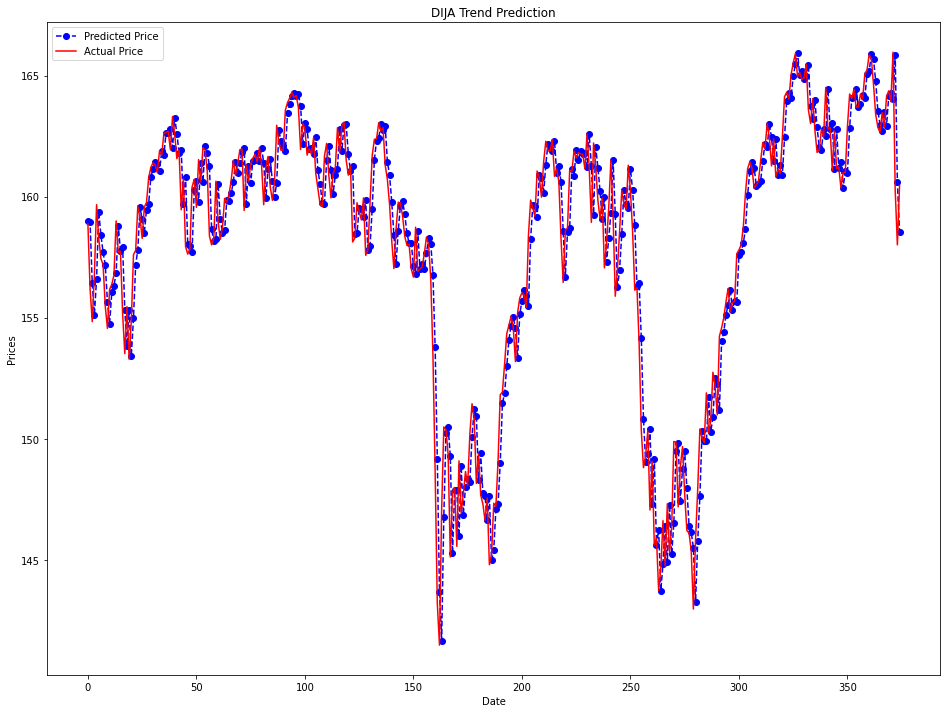

In [28]:
#test_set_range = stock_with_predictions[int(len(stock_with_predictions)*0.7):].index
plt.figure(figsize=(16, 12))
plt.plot(arima_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(target_test_data, color='red', label='Actual Price')
plt.title('DIJA Trend Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
#plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.show()

## Stock Backtesting Stuff

### Simple vectorized estimates

* Long model buys when sentiment is positive, sells when not
* Long short model buys when sentiment is positive and shorts when it is negative 

In [ ]:
#class Backtesting():
#   def __init__(self, stock_data, label_data, initial_value):
#     self.stock = stock_data
#     self.label = label_data
#     self.output_df = self.stock
#     self.init_val = initial_value
#     self.liquid = True
#     self.shares = 0
#     self.cur_val = self.init_val


In [29]:
import numpy as np

# Vectorized simple solution in function form, class to follow after expansion including plotting etc.
def simple_backtest(start_date, predictions, stock_data, arima_pred = 0, arima = False, combo = False, arima_weight = 1, sentiment_weight = 10, arima_thresh = 0, end_date = '2016-07-01'):
  test_stock_data = stock_data.loc[(stock_data['<DATE>'] >= start_date) & (stock_data['<DATE>'] <= end_date)]
  test_stock_data = stock_data[stock_data['<DATE>'] > start_date]
  test_stock_data = test_stock_data.reset_index()

  if arima:
    pred_df = pd.DataFrame(arima_pred, columns=['Arima_pred'])
    pred_df['Sentiment_pred'] = pd.DataFrame(predictions, columns=['Sentiment'])
    pred_df.loc[pred_df['Sentiment_pred'] < 1, 'Sentiment_pred'] = -1

  else:
    pred_df = pd.DataFrame(predictions, columns=['Sentiment'])

  pred_df['Open'] = test_stock_data['<OPEN>']
  pred_df['Close'] = test_stock_data['<CLOSE>']
  pred_df['Date'] = test_stock_data['<DATE>']
  # Shift percent change so that the next day's percent change is in line with the sentiment
  pred_df['Change'] = pred_df['Close'].pct_change().shift(-1).dropna()
  
  if arima:
    pred_df['Predicted change'] = pred_df['Arima_pred'] - pred_df['Close']

    pred_df.loc[pred_df['Predicted change'] >= arima_thresh, 'Pos_change'] = pred_df['Change']
    pred_df.loc[pred_df['Predicted change'] < arima_thresh, 'Pos_change'] = 0

    pred_df.loc[pred_df['Predicted change'] <= arima_thresh*(-1),'Pos_change_shrt'] =  pred_df['Change']*(-1)
    pred_df.loc[pred_df['Predicted change'] > arima_thresh*(-1),'Pos_change_shrt'] =  0

    if combo:
      # pred_df.loc[(pred_df['Predicted change']*arima_weight + pred_df['Sentiment_pred']*sentiment_weight) >= arima_thresh, 'Pos_change'] = pred_df['Change']
      # pred_df.loc[(pred_df['Predicted change']*arima_weight + pred_df['Sentiment_pred']*sentiment_weight) < arima_thresh, 'Pos_change'] = 0

      # pred_df.loc[(pred_df['Predicted change']*arima_weight + pred_df['Sentiment_pred']*sentiment_weight) <= arima_thresh,'Pos_change_shrt'] =  pred_df['Change']*(-1)
      # pred_df.loc[(pred_df['Predicted change']*arima_weight + pred_df['Sentiment_pred']*sentiment_weight) > arima_thresh,'Pos_change_shrt'] =  0

      pred_df.loc[(pred_df['Predicted change']*arima_weight + pred_df['Predicted change']*pred_df['Sentiment_pred']*sentiment_weight) >= arima_thresh, 'Pos_change'] = pred_df['Change']
      pred_df.loc[(pred_df['Predicted change']*arima_weight + pred_df['Predicted change']*pred_df['Sentiment_pred']*sentiment_weight) < arima_thresh, 'Pos_change'] = 0

      # pred_df.loc[(pred_df['Predicted change']*arima_weight + pred_df['Predicted change']*pred_df['Sentiment_pred']*sentiment_weight) <= arima_thresh,'Pos_change_shrt'] =  pred_df['Change']*(-1)
      # pred_df.loc[(pred_df['Predicted change']*arima_weight + pred_df['Predicted change']*pred_df['Sentiment_pred']*sentiment_weight) > arima_thresh,'Pos_change_shrt'] =  0

  else:
    # Setup column for changes that our position will be exposed to (while we're bought in)
    pred_df['Pos_change'] = pred_df['Sentiment'] * pred_df['Change']
    # # Setup column for long and short returns
    pred_df.loc[pred_df['Sentiment'] < 1 ,'Pos_change_shrt'] =  pred_df['Change']*(-1)
    pred_df.loc[pred_df['Sentiment'] >= 1 ,'Pos_change_shrt'] =  0
    # pred_df['Pos_change_shrt'] = pred_df['Sentiment'] * pred_df['Change']*(-1)# + pred_df['Pos_change']

  # Calculate cumulative return for dow jones, long positions, and long/short positions
  pred_df['Cumul_ret_dji'] = np.exp(np.log1p(pred_df['Change']).cumsum())
  pred_df['Cumul_ret_long'] = np.exp(np.log1p(pred_df['Pos_change']).cumsum())
  # pred_df['Cumul_ret_long_shrt'] = (np.exp(np.log1p(pred_df['Pos_change']).cumsum()) + np.exp(np.log1p(pred_df['Pos_change_shrt']).cumsum()))/2
  return pred_df

In [30]:
news_predictions = generic_forrest.predictions
reddit_predictions = reddit_forrest.predictions

stock_data = dia_data.data.reset_index()
# randomforrest
pred_df_forrest = simple_backtest('2014-12-31', news_predictions, stock_data)

pred_df_reddit_forest = simple_backtest('2014-12-31', reddit_predictions, stock_data)
# xgboost
pred_df_xgboost = simple_backtest('2014-12-31', dia_pred, stock_data)

# arima
pred_df_arima = simple_backtest('2014-12-31', news_predictions, stock_data, arima_predictions, arima_thresh = .1, arima = True)

#combo arima forest
pred_df_arima_forest = simple_backtest('2014-12-31', news_predictions, stock_data, arima_predictions, arima_thresh = .1, arima_weight = 2, sentiment_weight = 1, arima = True, combo = True)

pred_df_arima

,Arima_pred,Sentiment_pred,Open,Close,Date,Change,Predicted change,Pos_change,Pos_change_shrt,Cumul_ret_dji,Cumul_ret_long
0,159.008438,1,159.56,158.87,2015-01-02,-0.016869,0.138438,-0.016869,0.000000,0.983131,0.983131
1,158.945960,-1,158.12,156.19,2015-01-05,-0.008643,2.755960,-0.008643,0.000000,0.974633,0.974633
2,156.416958,-1,156.39,154.84,2015-01-06,0.012787,1.576958,0.012787,0.000000,0.987096,0.987096
3,155.134785,1,156.20,156.82,2015-01-07,0.018174,-1.685215,0.000000,-0.018174,1.005036,0.987096
4,156.620256,1,158.30,159.67,2015-01-08,-0.008831,-3.049744,0.000000,0.008831,0.996160,0.987096
...,...,...,...,...,...,...,...,...,...,...,...
370,164.291355,1,164.53,163.92,2016-06-22,0.012506,0.371355,0.012506,0.000000,1.044691,1.117728
371,164.031241,1,165.22,165.97,2016-06-23,-0.034344,-1.938759,0.000000,0.034344,1.008812,1.117728
372,165.856376,1,161.12,160.27,2016-06-24,-0.014101,5.586376,-0.014101,0.000000,0.994587,1.101967
373,160.608588,1,159.18,158.01,2016-06-27,0.015505,2.598588,0.015505,0.000000,1.010008,1.119053


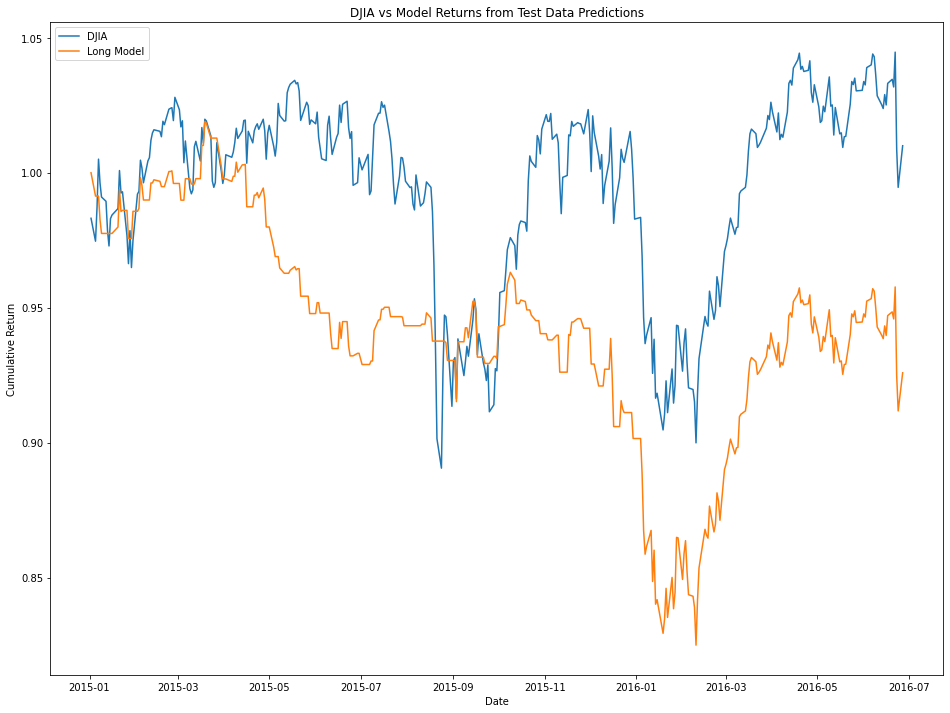

In [31]:
# Plot results
import matplotlib.pyplot as plt
%matplotlib inline

def plot_backtest(prediction_df, title='DJIA vs Model Returns from Test Data Predictions', label_1='DJIA', label_2='Long Model', label_3='Long/Short Model'):
  pred_df = prediction_df

  plt.figure(figsize=(16, 12)) 
  plt.plot(pred_df['Date'], pred_df['Cumul_ret_dji'], label = label_1)
  plt.plot(pred_df['Date'], pred_df['Cumul_ret_long'], label = label_2)
  # plt.plot(pred_df['Date'], pred_df['Cumul_ret_long_shrt'], label = label_3)
  plt.xlabel('Date')
  plt.title(title)
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

plot_backtest(pred_df_xgboost)

In [ ]:
plot_backtest(pred_df_arima_forest)

In [ ]:
plot_backtest(pred_df_forrest)

In [ ]:
plot_backtest(pred_df_reddit_forest)

In [ ]:
plot_backtest(pred_df_arima)

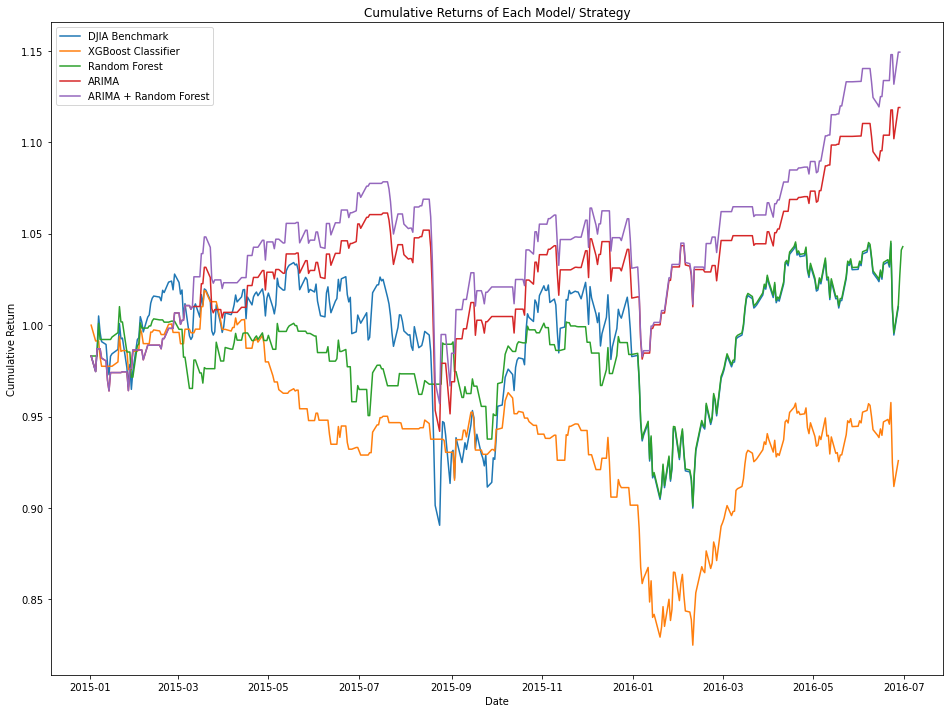

In [32]:
plt.figure(figsize=(16, 12)) 
plt.plot(pred_df_xgboost['Date'], pred_df_xgboost['Cumul_ret_dji'], label = 'DJIA Benchmark')
plt.plot(pred_df_xgboost['Date'], pred_df_xgboost['Cumul_ret_long'], label = 'XGBoost Classifier')
plt.plot(pred_df_forrest['Date'], pred_df_forrest['Cumul_ret_long'], label = 'Random Forest')
plt.plot(pred_df_arima['Date'], pred_df_arima['Cumul_ret_long'], label = 'ARIMA')
plt.plot(pred_df_arima_forest['Date'], pred_df_arima_forest['Cumul_ret_long'], label = 'ARIMA + Random Forest')

# plt.plot(pred_df['Date'], pred_df['Cumul_ret_long_shrt'], label = label_3)
plt.xlabel('Date')
plt.title('Cumulative Returns of Each Model/ Strategy')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()